# Agricultural Drought Risk Assessment

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [DROUGHTS](https://github.com/CLIMAAX/DROUGHTS) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

In this workflow we will visualise the revenue losses deriving from the reduction in crops yield due to precipitation scarcity and  absence of irrigation. This assessment is particularly relevant for semi-arid regions (e.g., Mediterranean) which are increasingly prone to  prolonged drought periods making artificial irrigation unfeasible at times, as well as historically wet regions (e.g., Central and Northern Europe) that have not yet implemented artificial irrigation at large-scale but might experience a significant decline in precipitation rates with future climate change.

<figure class="align-center">
  <iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/_2KtWBMfV-U?si=4u5InRV6CMKxnJua" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>
</figure>

## Risk Assessment methodology

The risk assessment methodology is described in detail in the [description](AGRICULTURE_Risk_workflow_description.md) file. In summary, data on  total crop production [ton] and revenue [EUR] is combined with the yield loss reduction calculated in the [hazard](AGRICULTURE_DROUGHT_Hazard.ipynb) workflow to derive a map of the revenue loss from absence of irrigation. Revenue loss is expressed here as the 'lost opportunity cost' of not using irrigation. The maps also shows the distribution of existing irrigation systems, which are used as a proxy of vulnerability to precipitation scarcity. The assessment is currently available for the same 14 crops available for the hazard assessment, but the selection can be expanded by modifying the [crop table](crop_table.csv). 

### Limitations

The main limitation of this approach is the fact that the crop production, aggregated value and irrigation distribution datasets refer to 2010 values and might not be accurately representative of current conditions.
The user is invited to replace these datasets with more updated information whenever possible.
The limitations of the yield loss calculation procedure are discussed in the [hazard](AGRICULTURE_DROUGHT_Hazard.ipynb) workflow.
The calculation of revenue loss as implemented in this workflow assumes that:

- There is a linear relationship between value and production, i.e., the crops with highest production in tons generate the highest revenue.
  This is not true in reality, but most of the crops treated in MapSPAM are staple/cereal, so their value per unit is not expected to vary much.
  However, for crops with high values per ton (e.g., wine grapes), this assumption will lead to inaccuracies.
- The cultivated area for each crop does not change within each pixel, so that a decrease in yield leads to a linear decrease in production. 

## Load libraries
In this notebook we will use the following Python libraries:

In [1]:
import json
import os
import re
import urllib
import zipfile

import pooch
import pyDataverse.api

import pandas as pd
import numpy as np
import rasterio
import geopandas as gpd
import shapefile
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

:::{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [re](https://docs.python.org/3/library/re.html) - To modify file names.
- [zipfile](https://docs.python.org/3/library/zipfile.html) - To extract files from zipped folders.
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - To download data from various repositories.
- [pyDataverse](https://pydataverse.readthedocs.io/en/latest/) - To download data from Harvard Dataverse. 
- [numpy](https://numpy.org/doc/stable/index.html) - To make calculations and handle data in the form of arrays.
- [pandas](https://pandas.pydata.org/docs/index.html) - To store data in the form of DataFrames.
- [geopandas](https://geopandas.org/en/stable/index.html) - To read georeferenced files as DataFrames.
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - To access and explore geospatial raster data in GeoTIFF format.
- [matplotlib](https://matplotlib.org/) and [cartopy](https://scitools.org.uk/cartopy/docs/latest/index.html) - For plotting.
:::

## Create the directory structure
First, we need to set up the directory structure to make the workflow work.
The next cell will create the directory called 'agriculture_workflow' in the same directory where this notebook is saved. A directory for data and one for results will also be created inside the main workflow directory to store the downloaded data and the final plots. 

In [2]:
workflow_dir = 'agriculture_workflow'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_dir, 'data')
results_dir = os.path.join(workflow_dir, 'results')

# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_dir):
    os.makedirs(workflow_dir)
    os.makedirs(data_dir)
    os.makedirs(results_dir)

## Define the studied area


The cells below allows to download the boundaries of any NUTS2 region in the EU as a GeoJson file given the region code (in this case ES51 for Catalunya). You can look up the NUTS2 code for all EU regions [here](https://ec.europa.eu/eurostat/documents/3859598/15193590/KS-GQ-22-010-EN-N.pdf) by simply searching the document for the region name. 

The coordinates of the selected regions are extracted and saved in an array. Finally, the geometry of the GeoJson file is saved as a shapefile to be used in the plotting phase.

In [3]:
region = ['ES51'] #Replace the code in [''] with that of your region 

In [4]:
#auxiliary function to load region GeoJson file.
def load_nuts_json(json_path):
    # dependencies: json, urllib, geopandas, 
    while True:
        uh = urllib.request.urlopen(json_path)
        data = uh.read()
        break  
    gdf = gpd.GeoDataFrame.from_features(json.loads(data)["features"])
    gdf['Location'] = gdf['CNTR_CODE'] 
    gdf = gdf.set_index('Location')
    #gdf.to_crs(pyproj.CRS.from_epsg(4326), inplace=True)
    return gdf

# load nuts2 spatial data
json_nuts_path = 'https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_10M_2021_4326_LEVL_2.geojson'
nuts = load_nuts_json(json_nuts_path)
nuts = nuts.loc[nuts['NUTS_ID'].isin(region)]

#extract coordinates
df=gpd.GeoSeries.get_coordinates(nuts)
coords_user=df.to_numpy()

#save geometry as shapefile
nuts_name=re.sub(r'[^a-zA-Z0-9]','',str(nuts.iloc[0,4]))
nuts_shape=nuts.geometry.explode(index_parts=True).to_file(f'{data_dir}/{nuts_name}.shp')

The code below creates the study area bounding box using the coordinates of the region GeoJson file. 

In some cases, it might be needed to expand the selected area through the 'scale' parameter to avoid the corners of the region being left out from the data extraction. The units of the 'scale' parameter are degrees, so setting scale=1 will increase the extraction area by approximately 100 km. A scale of 0-0.5 should be sufficient to fully cover most regions.  

:::{warning} The larger the scale parameter, the larger the extracted area, the longer the workflow will run for. Thus, the user is invited to have a first run of the workflow with scale=0.5, then increase it if not satisfied with the data coverage of the final map.

In [5]:
# Defining the region bounding box, scale parameter can be adjusted 
scale = 0.5
bbox = [
    np.min(coords_user[:,0]) - scale,
    np.min(coords_user[:,1]) - scale,
    np.max(coords_user[:,0]) + scale,
    np.max(coords_user[:,1]) + scale
]

## Import hazard data 

To run the risk assessment workflow you will first need to import data from the [hazard](AGRICULTURE_DROUGHT_Hazard.ipynb) workflow. If you have already run the hazard workflow you can ignore the cell below. If you have not, cancel the '#' in the cell below to activate the code and run it to start the hazard workflow creating the files needed for the risk assessment. This might take a few minutes.

::: {warning} The hazard assessment workflow uses Catalunya as a default region. If you want to run the risk workflow for a different region, change the selection in the [hazard](AGRICULTURE_DROUGHT_Hazard.ipynb) workflow first.

In [6]:
#%run AGRICULTURE_DROUGHT_Hazard.ipynb

Run the cell below to load data from the hazard assessment and visualise them.

In [7]:
# Load yield loss data from the .npy and .csv files produced by the hazard workflow
yield_loss_perc = np.load(f'{results_dir}/{nuts.iloc[0,4]}_yield_loss_NUMPY.npy')
hazard_df = pd.read_csv(f'{results_dir}/{nuts.iloc[0,4]}_yield_loss_SPREADSHEET.csv')

# Extract the lat-lon coordinates from the hazard dataframe for resampling of other fields
coords_11 = np.stack((hazard_df['lon'].to_numpy(), hazard_df['lat'].to_numpy()), axis=1)

# Reference shape of a lat-lon field
fields_shape = yield_loss_perc.shape[0:2]

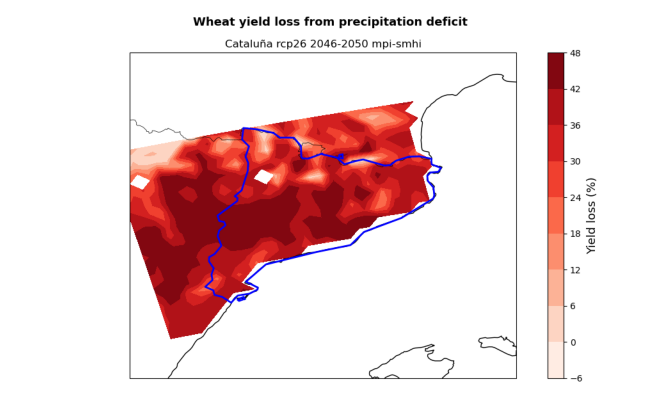

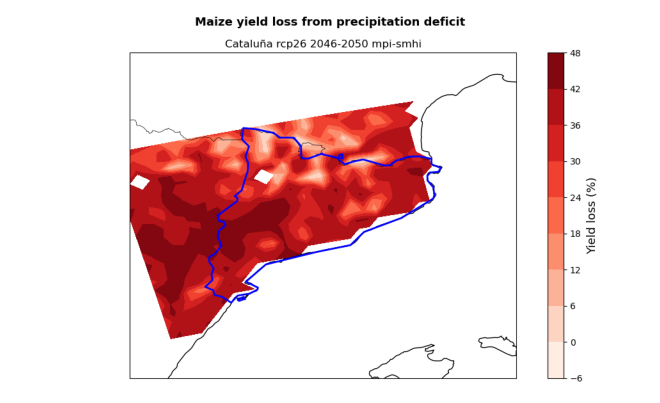

In [8]:
# Visualise the yield loss maps produced by the hazard workflow
hazard_files = [x for x in os.listdir(results_dir) if (nuts.iloc[0,4] in x and 'yield_loss.png' in x)]

for i in hazard_files:
    img = mpimg.imread(f'{results_dir}/{i}',format='png')
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_axis_off()
    plt.imshow(img)
    plt.show()

## Download and extract Exposure data
### 1. Crops Production  

Next we will need data on crop production to calculate exposure.
Crop production [ton] data for 2020 is retrieved from the [MapSPAM repository](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/SWPENT) on Harvard Dataverse.
Data is available as global `.tif` rasters at 5 arc-min resolution for different combinations of human inputs and irrigation modes.
In this assessment, we will use data for crops grown under 'high' human inputs and 'all' irrigation modes.
46 files are downloaded for the 2020 dataset, one for each crop available on the MapSPAM repository.
The step-by-step download procedure is explained within the code below.

In [8]:
# Set up the API to retrieve the SPAM dataset from Harvard Dataverse given the DOI 
base_url = 'https://dataverse.harvard.edu/'
api = pyDataverse.api.NativeApi(base_url)

# Retrieve and display the list of available files for the SPAM dataset
dataset = api.get_dataset('doi:10.7910/DVN/SWPENT')
files_list = dataset.json()['data']['latestVersion']['files']
for file in files_list:
    print("ID {id}, Filename: {filename}".format(**file["dataFile"]))

ID 11596408, Filename: Readme_SPAM2020V2r0.txt
ID 11596409, Filename: spam2020V2r0_global_harvested_area.csv.zip
ID 11596412, Filename: spam2020V2r0_global_harvested_area.geotiff.zip
ID 11596414, Filename: spam2020V2r0_global_physical_area.csv.zip
ID 11596411, Filename: spam2020V2r0_global_physical_area.geotiff.zip
ID 11596413, Filename: spam2020V2r0_global_production.csv.zip
ID 11596407, Filename: spam2020V2r0_global_production.geotiff.zip
ID 11596410, Filename: spam2020V2r0_global_yield.csv.zip
ID 11596406, Filename: spam2020V2r0_global_yield.geotiff.zip


:::{tip}
You might be interested in other files in the SPAM directory than the production ones used in this workflow. In the list above, you can find the ID code needed to download them.
In this workflow we are using the global production GeoTIFF file and associated download ID.
:::

In [9]:
# Specify path where the downloaded zip file will be saved
spam_path = os.path.join(data_dir, 'spam_prod_geotiff.zip')

# Download the dataset for crops production given the ID
download_id = '11596407'

data_api = pyDataverse.api.DataAccessApi(base_url)
response = data_api.get_datafile(download_id, is_pid=False)
with open(spam_path, "wb") as f:
    f.write(response.content)

# Extract the SPAM files, select the 'all' irrigation files only
with zipfile.ZipFile(spam_path, 'r') as zObject:
    selected_files = [x for x in zObject.namelist() if '_A.tif' in x]
    zObject.extractall(path=data_dir, members=selected_files)

# Get output folder name from zip archive structure
spam_folder = os.path.join(data_dir, os.path.dirname(selected_files[0]))

To select the SPAM files for the crops you are interested in, you will have to correctly specify their name.
Run the cell below to print the list of available crops.
In the SPAM files, crops are identified by a 4-letter acronym in capital letters.
For example, cotton is `COTT` and wheat is `WHEA`.

In [10]:
print(", ".join(f.split("_")[-2] for f in selected_files))

BANA, BARL, BEAN, CASS, CHIC, CITR, CNUT, COCO, COFF, COTT, COWP, GROU, LENT, MAIZ, MILL, OCER, OFIB, OILP, ONIO, OOIL, OPUL, ORTS, PIGE, PLNT, PMIL, POTA, RAPE, RCOF, REST, RICE, RUBB, SESA, SORG, SOYB, SUGB, SUGC, SUNF, SWPO, TEAS, TEMF, TOBA, TOMA, TROF, VEGE, WHEA, YAMS


Now copy the acronym of the crops you want to study into the cell below and run it.

:::{note}
You can only get results for the crops parameterised in the [crop table](crop_table.ipynb) (14 are included the provided table).
:::

In this example, we are interested in wheat and maize.

In [11]:
spam_list = ['MAIZ', 'WHEA']

The cell below extracts data from the SPAM files, first for the studied crops then for all available crops.


In [12]:
# Extraction of studied crops production 
df_spam = pd.DataFrame()
for i in os.listdir(spam_folder):
    for a in np.arange(len(spam_list)):
        if spam_list[a] in i:
            raster_path = os.path.join(spam_folder, i)
            with rasterio.open(raster_path) as src:
                values = [x[0] for x in src.sample(coords_11)]
            # Create a new column for each raster
            df_spam[spam_list[a]] = values

crops_spam = df_spam.to_numpy(dtype='float64')
crops_spam[crops_spam < 0] = np.nan
crops_spam = crops_spam.reshape((*fields_shape, len(spam_list)))

# Extraction of all crops production
df_spam_all = pd.DataFrame()
for i in os.listdir(spam_folder):
    if not i.endswith(".tif"):
        continue
    raster_path = os.path.join(spam_folder, i)
    with rasterio.open(raster_path) as src:
        values = [x[0] for x in src.sample(coords_11)]

    # Create a new column for each raster
    df_spam_all[i] = values

df_spam_sum = df_spam_all.sum(axis=1)
spam_sum = df_spam_sum.to_numpy(dtype='float64')
spam_sum[spam_sum < 0] = np.nan
spam_sum = spam_sum.reshape(fields_shape)

### 2. Crops Aggregated Value

The second exposure dataset we need is about crops aggregated value.
We source data from the FAO [Global Agro-Ecological Zones](https://www.fao.org/gaez/en/) (GAEZ) dataset v5 for year 2020 ([model documentation](https://github.com/un-fao/gaezv5/wiki)).
Data is available as global `.tif` rasters at approximately 11 km resolution showing the aggregated crops value in 2015 international dollars (I$), having the same purchasing power of US dollars (USD).

In [14]:
gaez_path = os.path.join(data_dir, 'GAEZ-V5.RES06-VAL.ALL.WST.tif')

pooch.retrieve(
    url='https://storage.googleapis.com/fao-gismgr-gaez-v5-data/DATA/GAEZ-V5/MAPSET/RES06-VAL/GAEZ-V5.RES06-VAL.ALL.WST.tif',
    known_hash='4e333cc83045d61d6fc7538d43438c2eeb0be5e6bc5f6cd7788f383376c91fac',
    path=os.path.dirname(gaez_path),
    fname=os.path.basename(gaez_path)
)

The cell below extracts aggregated value data from the raster and stores them as an array.

In [15]:
with rasterio.open(gaez_path) as src:
    val_gaez = np.asarray([x[0] for x in src.sample(coords_11)], dtype=np.float64)

val_gaez[val_gaez < 0] = np.nan
val_gaez = val_gaez.reshape(fields_shape)

## Download and extract Vulnerability data - Irrigation availability

Next we will need data on cropland full-irrigation availability to define vulnerability. This dataset is also sourced from GAEZ and is available at the same resolution as the aggregated value data. The dataset shows the percentage of cropland in each grid-cell equipped with irrigation systems.  

In [15]:
pooch.retrieve(
    url='https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/LR/wat/GLCSv11_12_5m.tif',
    fname='GLCSv11_12_5m.tif',
    known_hash='798437a7c5bfa5887c5dd9eacb42b7388db9e4f3073b3c8d4cf4e5d6c9bcedb7',
    path=data_dir
)

The cell below extracts irrigation availability data from the raster and stores them as an array.

In [16]:
# Extract irrigation availability data
raster_path = f'{data_dir}/GLCSv11_12_5m.tif'
irr_share = pd.DataFrame()
with rasterio.open(raster_path) as src:
    values = [x[0] for x in src.sample(coords_11)]
irr_share['irr'] = values
irr_share = irr_share.to_numpy(dtype='float64')
irr_share = irr_share.reshape(fields_shape)

## Data processing

To determine the economic value per pixel of the studied crops and estimate corresponding revenue losses, we:

1. Define the share of total crop production represented by the studied crops
2. Multiply the total revenue per pixel by the share of the total production to get the revenue of the studies crops in each grid cell (USD/cell)
3. Multiply the revenue per grid-cell with the yield loss calculated in the hazard workflow to get the reduced revenue due to absence of irrigation (USD/cell)
4. Convert the results from USD to EUR using the 2015 average exchange rate

In [17]:
# 1. Fraction of total production represented by the studied crops
crop_prod_fraction = crops_spam / spam_sum[:,:,None]

# 2. Studied crops revenue per pixel
rev_per_pixel_crop = val_gaez[:,:,None] * crop_prod_fraction

# 3. Studied crops revenue loss
revenue_loss = rev_per_pixel_crop * yield_loss_perc / 100.

# 4. From USD to EUR at 2020 average exchange rate
revenue_loss_euro = revenue_loss / 1.11

:::{tip}

Adjust the exchange rate factor to further account for inflation or to convert to a different currency.
:::

## Plotting the results

The cell below allows to plot the revenue loss results for the studied region. The red shading shows the revenue loss per grid-cell for the studied crops deriving from the absence of irrigation. The hatching shows different levels of irrigation infrastructure availability within the region, highlighting areas of different vulnerability.

The resulting plot states the crop, RCP scenario and reference period used in the assessment. The plotting procedure steps are described within the cell.

:::{tip}

Use the `zoom` parameter to set how much you would like the final plot to be zoomed-out from the region boundaries (0=no zoom out, 1=100 km).
Here a zoom of 0.5 degrees (50 km) is used.
:::

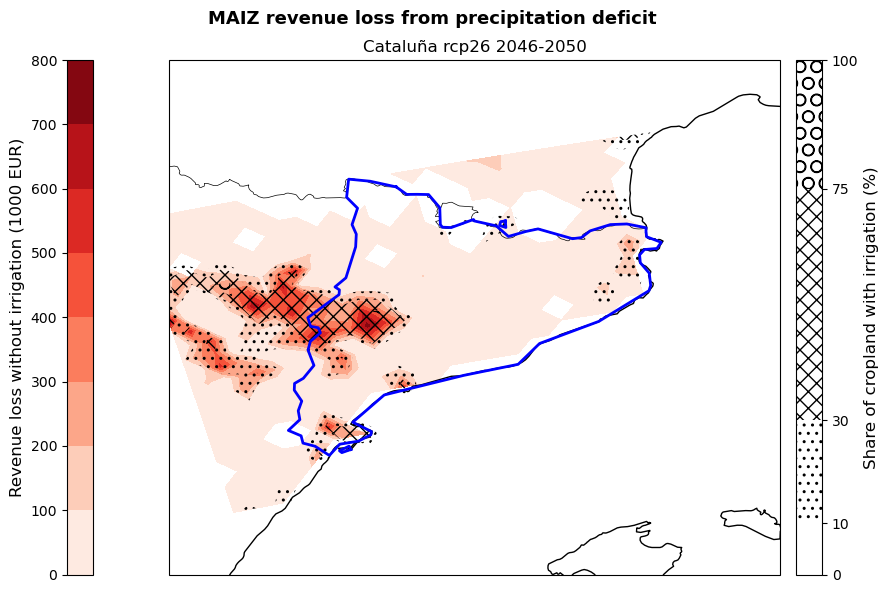

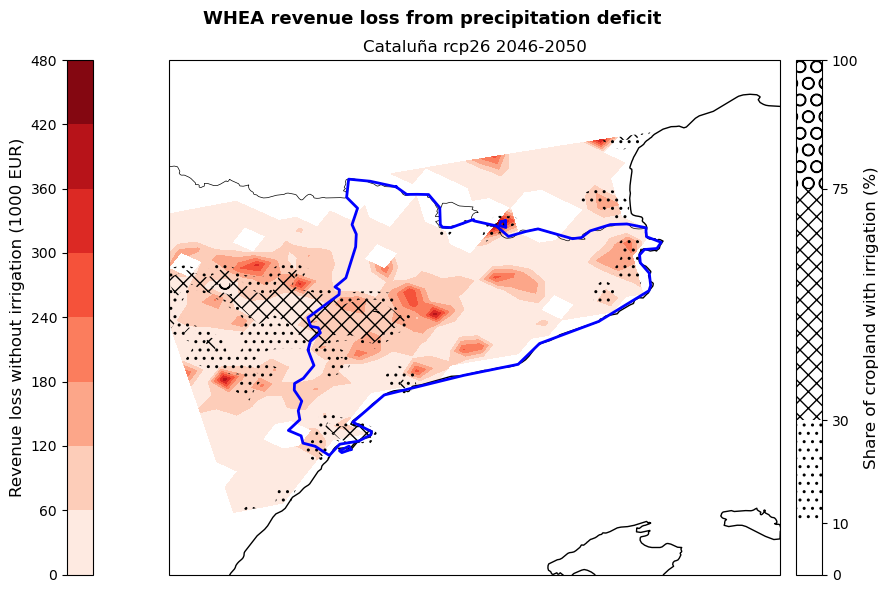

In [18]:
rcp = hazard_df['rcp'][0]  # identify the climate projection
ystart = hazard_df['start_year'][0]  # identify the projection start year
yend = hazard_df['end_year'][0]  # identify the projection end year

# Zoom parameter
zoom = 0.5

# Define the longitude and latitude coordinates
lon_plot = hazard_df['lon'].to_numpy().reshape(fields_shape)
lat_plot = hazard_df['lat'][:].to_numpy().reshape(fields_shape)

# Define irrigation vulnerability levels
irr_levels = np.array([0, 10, 30, 75, 100])

for a in np.arange(len(spam_list)):
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([bbox[0] - zoom, bbox[2] + zoom, bbox[1] - zoom, bbox[3] + zoom], crs=ccrs.PlateCarree())

    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    # Plot the revenue loss
    revenue_map = ax.contourf(lon_plot, lat_plot, revenue_loss_euro[:,:,a], cmap='Reds', transform=ccrs.PlateCarree(), zorder=1)
    revenue_cbar = fig.colorbar(revenue_map, ax=ax, orientation='vertical', location='left', pad=0.02)
    revenue_cbar.set_label('Revenue loss without irrigation (1000 EUR)', fontsize=12)

    # Plot the irrigation availability
    irr_map = ax.contourf(lon_plot, lat_plot, irr_share, colors='none', hatches=['', '..', 'xx', 'O'], 
                          transform=ccrs.PlateCarree(), levels=irr_levels, zorder=1)
    irr_cbar = fig.colorbar(irr_map, ax=ax, orientation='vertical', location='right', pad=0.02, spacing='proportional')
    irr_cbar.set_label('Share of cropland with irrigation (%)', fontsize=12)

    # Add shapefile data for region boundaries
    sf = shapefile.Reader(f'{data_dir}/{nuts_name}')
    for shape in sf.shapes():
        x = [point[0] for point in shape.points]
        y = [point[1] for point in shape.points]
        ax.plot(x, y, transform=ccrs.PlateCarree(), color='b', linewidth=2)

    # Titles
    plt.suptitle(f"{spam_list[a]} revenue loss from precipitation deficit", fontsize=13, fontweight='bold')
    plt.title(f"{nuts.iloc[0,4]} {rcp} {ystart}-{yend}")

    # Layout and save
    plt.tight_layout()
    plt.savefig(f'{results_dir}/{nuts.iloc[0,4]}_{spam_list[a]}_revenue_loss_EUR.png')
    plt.show()

The figures produced show the potential revenue losses from irrigation deficit in the studied region for the selected crops (here maize and wheat), emission scenario (here RCP2.6) and period (here 2046-2050). Losses are expressed by the red shading and represent the 'lost opportunity cost' in thousands euros if crops are grown under non-irrigated conditions. The hatches show the share of cropland in each grid-point with irrigation systems already implemented in 2010 and serves as an indicator of vulnerability to rainfall scarcity. 
<br>

These maps can be used by demonstrators to understand which areas of their region are expected to suffer the greatest losses, as well as which crops will be the most impacted by the absence of irrigation. This allows them to target adaptation efforts, such as the improvement of the current irrigation network, in the most affected and vulnerable areas favouring a cost-effective use of resources. At the same time, the map provides a snap-shot of a potential future growing season that can be used to guide cropland expansion towards areas and products less affected by water stress.


## Conclusions

Now that you were able to calculate damage maps based on yield loss maps and view the results, you can consider the following questions:

- How accurate do you think this result is for your local context? 
- What additional information are you missing that could make this assessment more accurate?
- What can you already learn from these maps of potential yield and revenue losses?

:::{important}

In this risk workflow we learned:

- how to access and use global datasets on crop production and irrigation availability.
- how to combine data on potential yield losses to the current crop production to estimate future potential revenue losses.
- how to use maps of irrigation distribution as a proxy for water-stress vulnerability.
:::

## Contributors

Euro-Mediterranean Center on Climate Change (CMCC), Italy.

Author of the workflow: Andrea Rivosecchi